#Fake detector
## Adam Paleczny, Mikołaj Słowikowski, Jarosław Skwarczek

In [1]:
!pip install tensorflow-addons -q
!pip install scikit-plot -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 6.8 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import re
import string
import matplotlib.pyplot as plt
from sklearn.metrics               import confusion_matrix                              # generate confusion matrix
from sklearn.metrics               import accuracy_score, recall_score, precision_score # performance assessment

In [3]:
import seaborn                as sns    # statistical data visualization
import tensorflow             as tf     # build machine learning models
import scikitplot             as skplt  # data visualization and machine-learning metrics

from tensorflow                    import keras                                         # build deep learning models
from wordcloud                     import WordCloud, STOPWORDS, ImageColorGenerator     # create wordcloud
from sklearn.model_selection       import train_test_split                              # split into training and test sets
from keras.preprocessing.text      import Tokenizer                                     # create tokens
from keras.preprocessing.sequence  import pad_sequences                                 # create padding
from keras.optimizers              import Adam                                          # optimizer for training neural networks
from sklearn.metrics               import confusion_matrix                              # generate confusion matrix
from sklearn.metrics               import accuracy_score, recall_score, precision_score # performance assessment
from sklearn.metrics               import classification_report
from sklearn.linear_model          import LogisticRegression
from keras.models                  import Sequential
from keras.layers                  import Embedding, Dense, LSTM
from keras.preprocessing.sequence  import pad_sequences
from keras.preprocessing.text      import one_hot

In [4]:
DATA = "/content/gdrive/My Drive/Projekt_MIO/dataset_PL/converted-exp-PL.tsv"

In [5]:
from google.colab import drive
import os
drive.mount('/content/gdrive')
os.chdir('/content/gdrive/My Drive/')

Mounted at /content/gdrive


## Data

In [118]:
df = pd.read_csv(DATA,sep='\t')
df.head()

,politicianID,name,party,statementID,statementText,statementState,statementExplanClean,statementExplan
0,1,Paweł Szałamacha,Prawo i Sprawiedliwość,1,"Pamiętamy, że w latach 2006-2007, kiedy rządzi...",TRUE,Według danych Banku Światowego wzrost polskieg...,"<p><span>Według danych </span><a href=""http://..."
1,1,Paweł Szałamacha,Prawo i Sprawiedliwość,2,"Jeżeli patrzymy na dane dla OECD, to Polska je...",TRUE,"Według danych z OECD, Polska znajduje się poni...","<p><span>Według </span><a href=""http://www.oec..."
2,1,Paweł Szałamacha,Prawo i Sprawiedliwość,3,Po kilkuletnim okresie dodatniego przyrostu na...,TRUE,Liczba urodzonych dzieci w Polsce na 1000 mies...,"<p><a href=""http://www.indexmundi.com/g/g.aspx..."
3,1,Paweł Szałamacha,Prawo i Sprawiedliwość,4,Jeszcze dwa dni wcześniej Bank Światowy podwyż...,TRUE,Według danych Banku Światowego zawartych w ana...,<p><span>Według danych Banku Światowego zawart...
4,1,Paweł Szałamacha,Prawo i Sprawiedliwość,5,Jeszcze dzień wcześniej Międzynarodowy Fundusz...,TRUE,W dniu 13 stycznia 2016 r. na stronie Międzyna...,<p><span>W dniu 13 stycznia 2016 r. na stronie...


In [97]:
df.columns

Index(['politicianID', 'name', 'party', 'statementID', 'statementText',
       'statementState', 'statementExplanClean', 'statementExplan'],
      dtype='object')

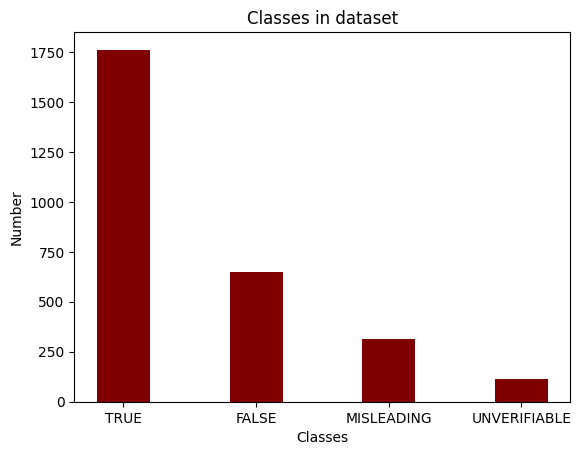

In [119]:
categories = df['statementState'].value_counts()

plt.bar(categories.index, categories.values, color ='maroon',
        width = 0.4)

plt.xlabel("Classes")
plt.ylabel("Number")
plt.title("Classes in dataset")
plt.show()

In [120]:
# How many empty labels
df.isnull().sum()

politicianID            0
name                    0
party                   0
statementID             0
statementText           0
statementState          0
statementExplanClean    0
statementExplan         0
dtype: int64

##Prepare for training

In [121]:
# create the 'clean_text' function that receives the 'text' argument
def clean_text(text):
    # create variable 'word' and divide the text by words and use whitespace as delimiter
    words = str(text).split()

    # convert words to lowercase by adding space to the end of each word
    words = [i.lower() + " " for i in words]

    # join words into a single string, but separated by spaces
    words = " ".join(words)

    # remove punctuation from strings, using the st.punctuation method as an argument
    words = words.translate(words.maketrans('', '', string.punctuation))

    return words

In [122]:
df['statementText'] = df['statementText'].apply(clean_text)
df['name'] = df['name'].apply(clean_text)
df['party'] = df['party'].apply(clean_text)

In [123]:
df = df.drop(columns=['politicianID', 'statementID', 'statementExplanClean', 'statementExplan'])

In [124]:
df['statementState'].value_counts()

statementState
TRUE            1761
FALSE            648
MISLEADING       313
UNVERIFIABLE     113
Name: count, dtype: int64

In [ ]:
train, df_temp = train_test_split(df, test_size=0.25, stratify=df['statementState'], shuffle=True, random_state=123)
validation, test = train_test_split(df, test_size=0.5,stratify=df['statementState'], shuffle=True, random_state=123)
statementStateMap = { "FALSE": 0, "TRUE": 1, "UNVERIFIABLE": 2, "MISLEADING": 3 }

In [ ]:
# converting strings to numbers of test Data
def convertToNumbers(x_data_of_strings, y_data_of_strings, vocab_size, sent_length):
    onehot_rep_train = [one_hot(word, vocab_size) for word in x_data_of_strings]
    ebedded_doc_train = pad_sequences(onehot_rep_train, padding='pre', maxlen = sent_length)
    state_train = np.array(list(map(statementStateMap.get, y_data_of_strings)))
    return ebedded_doc_train, state_train

## Sequence Model

In [ ]:
def SequenceModel():
    # some constants
    vocab_size = 20000
    features = 40
    sent_length = 120

    X_train, Y_train = convertToNumbers(train['statementText'], train['statementState'], vocab_size, sent_length)
    X_test, Y_test = convertToNumbers(validation['statementText'], validation['statementState'], vocab_size, sent_length)

    model = Sequential()
    model.add(Embedding(vocab_size, features, input_length = sent_length))
    model.add(LSTM(100))
    # In Keras, LSTM layer LSTM(100), the number 100 represents the number of units or neurons in the LSTM layer.
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam' , metrics=['accuracy'])
    print(model.summary())

    model.fit(X_train, Y_train, validation_data = (X_test, Y_test), epochs = 10 , batch_size=64)

    y_pred = np.where(model.predict(X_test) > 0.5, 1,0)
    print(np.sum(y_pred) / y_pred.shape[0])

In [ ]:
def LogisticRegressionModel():
    model = LogisticRegression()

    vocab_size = 20000
    sent_length = 120
    X_train, Y_train = convertToNumbers(train['statementText'], train['statementState'], vocab_size, sent_length)

    model.fit(X_train, Y_train)

    X_train_prediction = model.predict(X_train)
    training_data_accuracy = accuracy_score(X_train_prediction, Y_train)
    print(training_data_accuracy)

In [ ]:
SequenceModel()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 120, 40)           800000    
                                                                 
 lstm (LSTM)                 (None, 100)               56400     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 856501 (3.27 MB)
Trainable params: 856501 (3.27 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/10
34/34 [==============================] - 13s 272ms/step - loss: 0.1558 - accuracy: 0.6204 - val_loss: -0.2169 - val_accuracy: 0.6210
Epoch 2/10
34/34 [==============================] - 6s 184ms/step - loss: -0.2510 - accuracy: 0.6209 - val_loss: -0.3198 - val_accuracy

In [ ]:
LogisticRegressionModel()

0.6392285983066792


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Decision Tree Classifier

In [125]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier

# Assuming df is your original DataFrame
statement_to_int = {'TRUE': 1, 'FALSE': 2, 'MISLEADING': 3, 'UNVERIFIABLE': 4}

# Convert the statementState column to integers using the mapping dictionary
df['statementState'] = df['statementState'].map(statement_to_int)

# Split the data
X = df['statementText']
y = df['statementState']
train_statement, test_statement, train_class, test_class = train_test_split(X, y, test_size=0.25, random_state=123)

# Vectorize the text data
vectorization = TfidfVectorizer()
train_statement_vectorized = vectorization.fit_transform(train_statement)
test_statement_vectorized = vectorization.transform(test_statement)

# Train the model
model = DecisionTreeClassifier()
model.fit(train_statement_vectorized, train_class)

# Evaluate the model (optional)
predictions = model.predict(test_statement_vectorized)

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(test_class, predictions)
print(f'Accuracy: {accuracy}')


Accuracy: 0.48660084626234135


dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.665901 to fit


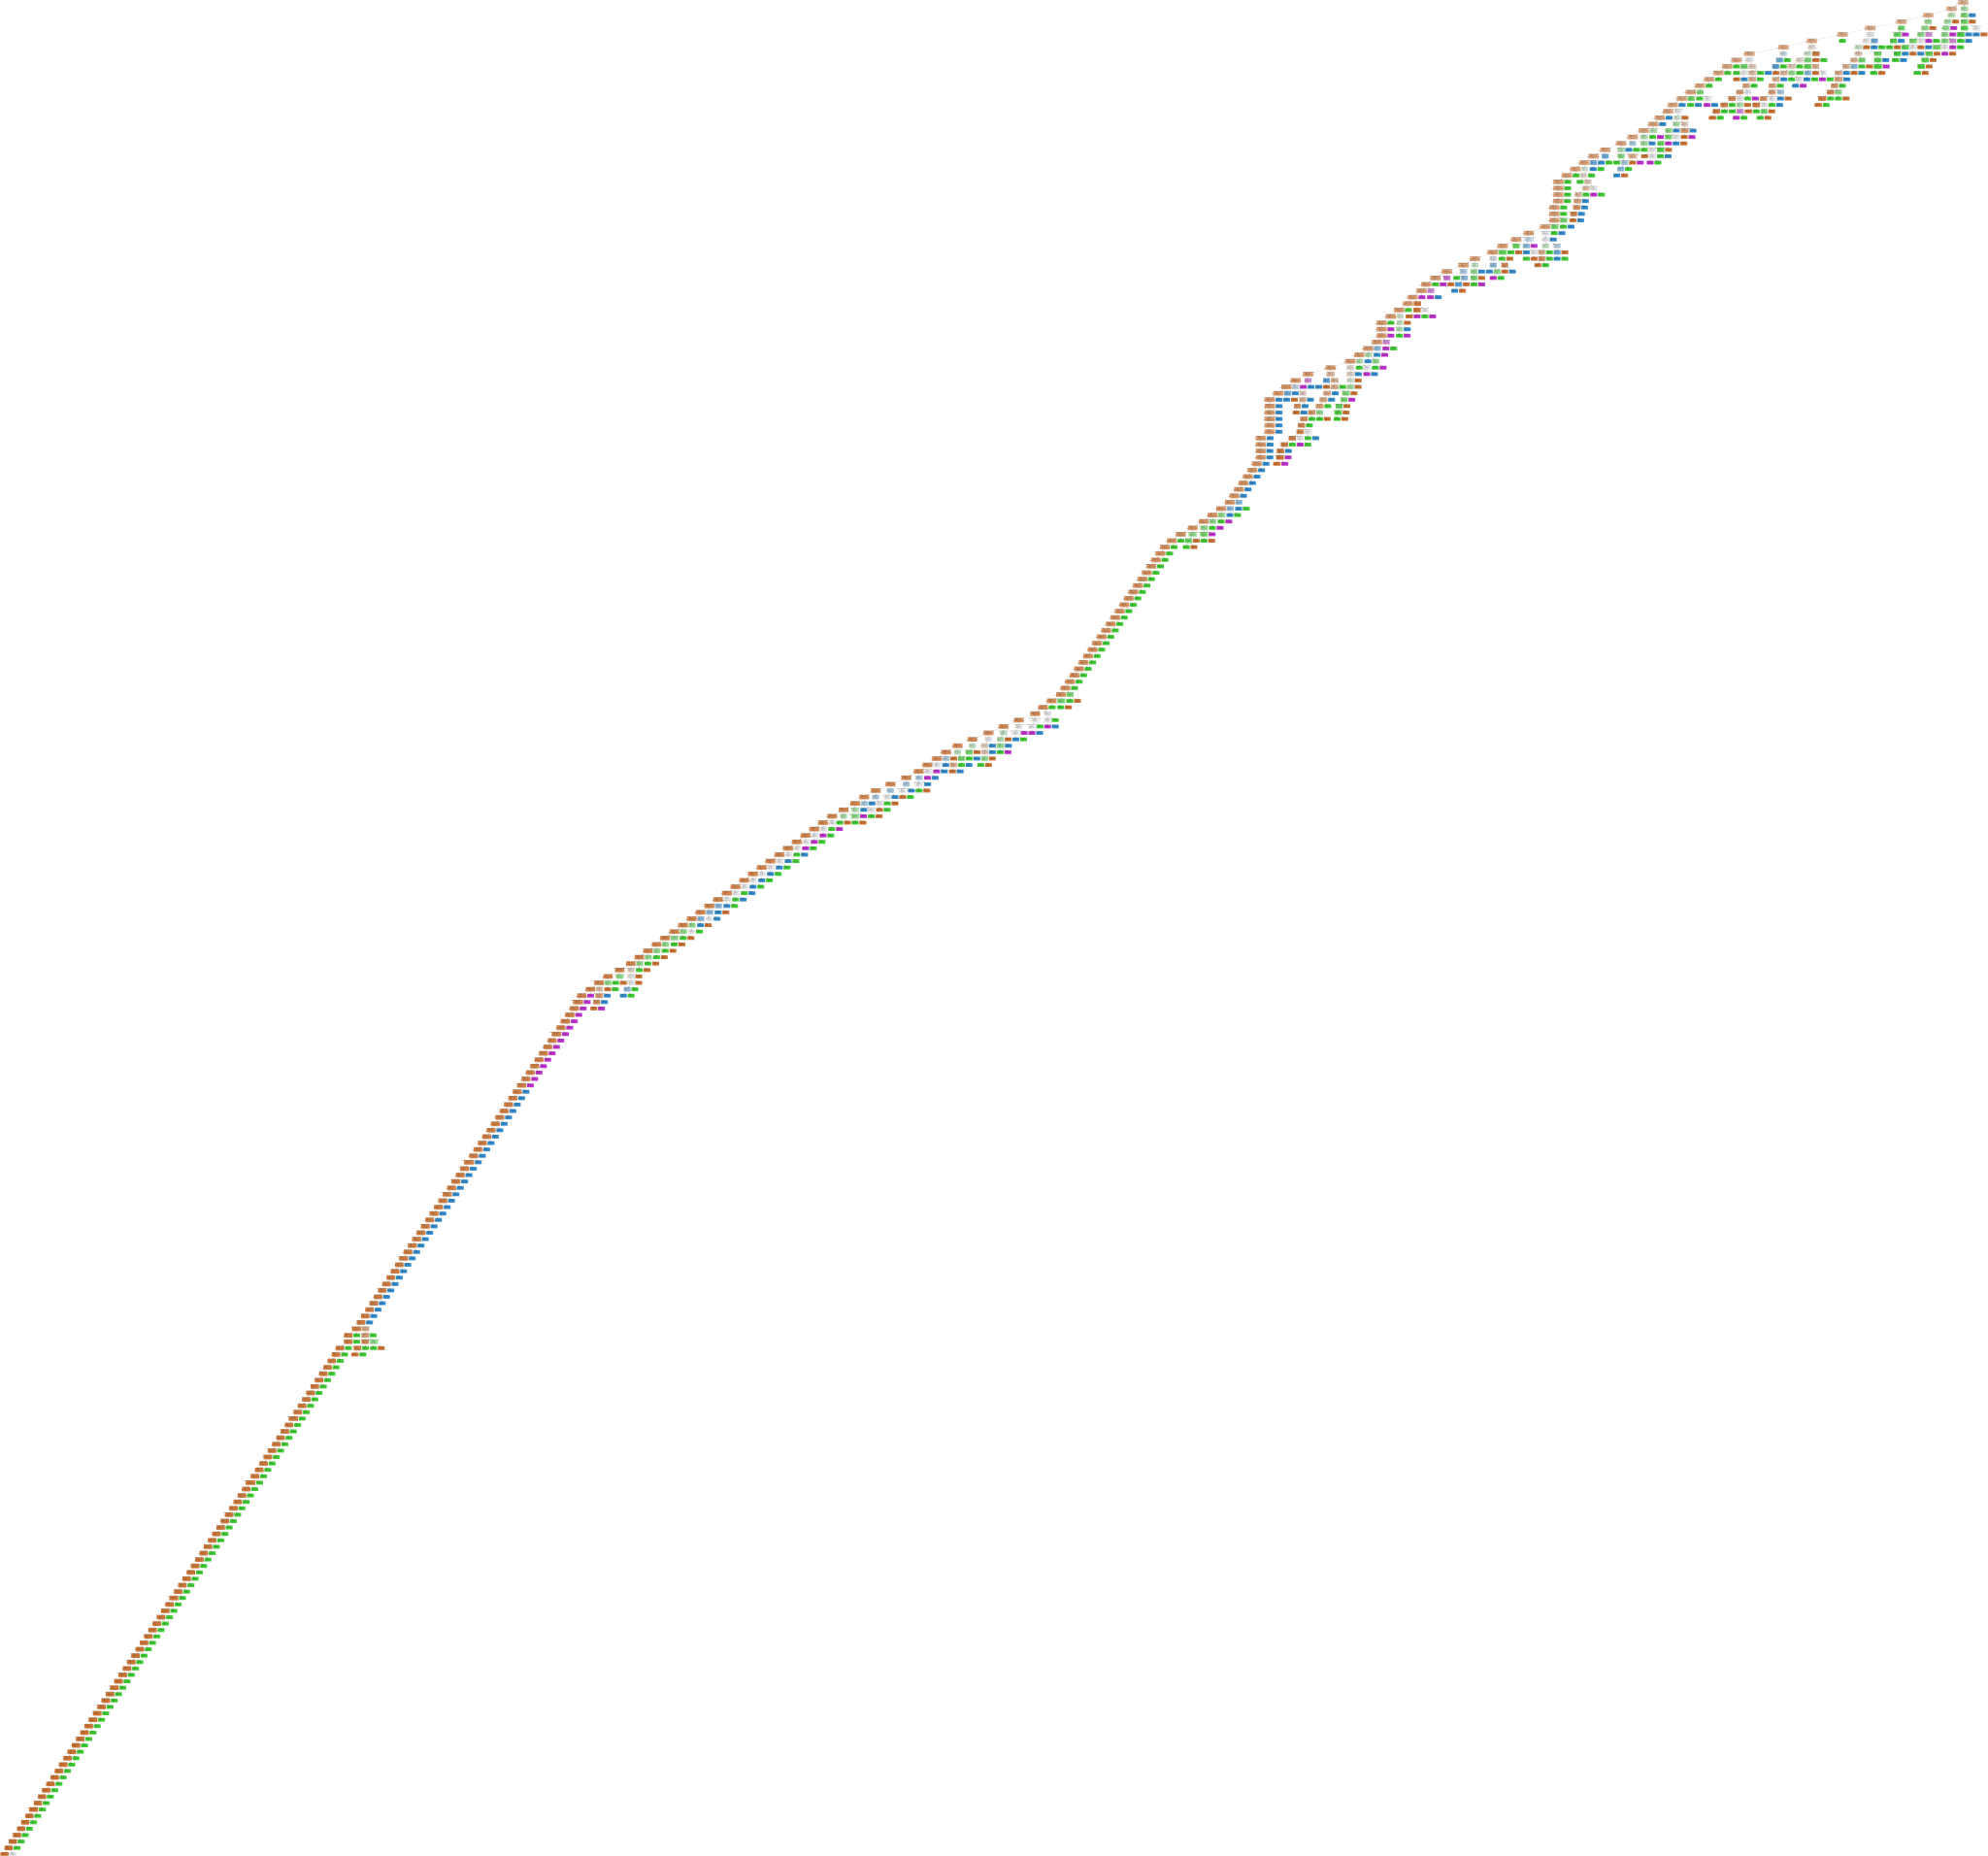

In [129]:
import graphviz
from sklearn import tree

# Get feature names from the TfidfVectorizer
feature_names = vectorization.get_feature_names_out()

# Get unique class names from the training labels
class_names = [str(label) for label in sorted(set(train_class))]

# Visualize the model
dot_decision_tree = tree.export_graphviz(model, out_file=None, feature_names=feature_names,
                                         class_names=class_names, filled=True)
decision_tree_plot = graphviz.Source(dot_decision_tree, format='png')
decision_tree_plot.render("decision_tree") # Save the plot as a file
decision_tree_plot # Display the plot
